<a href="https://colab.research.google.com/github/gabrielliman/Ising-Model/blob/main/IFC_IsingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numba import jit, njit, config, __version__, errors
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
@jit(nopython=True)
def vizinhos(N):
  #Define a tabela de vizinhos
  L=int(np.sqrt(N))
  viz = np.zeros((N,4),dtype=np.int16)
  for k in range(N):
    viz[k,0]=k+1
    if (k+1) % L == 0: viz[k,0] = k+1-L
    viz[k,1] = k+L
    if k > (N-L-1): viz[k,1] = k+L-N
    viz[k,2] = k-1
    if (k % L == 0): viz[k,2] = k+L-1
    viz[k,3] = k-L
    if k < L: viz[k,3] = k+N-L
  return viz

In [3]:
@jit(nopython=True)
def calcular_energia(s,viz):
  #Calcula a energia da configuração representada no array s
  N=len(s)
  ener = 0
  for i in range(N):
    h = s[viz[i,0]]+s[viz[i,1]] # soma do valor dos spins a direita e acima
    ener -= s[i]*h
  return ener

In [4]:
@jit(nopython=True)
def calcular_magnetizacao(s):
  return sum(s)

In [5]:
@jit(nopython=True)
def expos(beta):
  ex = np.zeros(5,dtype=np.float32)
  ex[0]=np.exp(8.0*beta)
  ex[1]=np.exp(4.0*beta)
  ex[2]=1.0
  ex[3]=np.exp(-4.0*beta)
  ex[4]=np.exp(-8.0*beta)
  return ex

In [6]:
def alg_metropolis(L, temp_inicial, n_passos = 1000):
  tam_rede = (L ** 2)  # Entre 24 ** 2 e 100 ** 2
  beta = 1/temp_inicial
  ex = expos(beta)
  s = [random.choice([-1, 1]) for _ in range(tam_rede)]
  viz = vizinhos(tam_rede)
  energias = np.zeros(n_passos)
  energia_atual = calcular_energia(s, viz)
  magnetizacoes = np.zeros(n_passos)
  magnetizacao_atual = calcular_magnetizacao(s)
  magnetizacao_atual = 0
  for iter in range(n_passos * tam_rede):
    i = random.randint(0, tam_rede-1)
    h = s[viz[i,0]]+s[viz[i,1]]+s[viz[i,2]]+s[viz[i,3]] # soma dos vizinhos
    de = int(s[i]*h*0.5+2)
    P = ex[de]
    r = random.uniform(0, 1)
    if (r <= P):
      energia_atual += 2 * s[i] * h
      magnetizacao_atual = magnetizacao_atual + (-1) * 2 * s[i]
      s[i] = -s[i]
    else:
      pass
    if (iter % tam_rede == 0):
      energias[int(iter/tam_rede)] = energia_atual
      magnetizacoes[int(iter/tam_rede)] = magnetizacao_atual
  return energias, magnetizacoes

In [7]:
def fazer_alg_metropolis_n_vezes(n, L, temp_inicial, n_passos = 1000):
  arr_energias = np.zeros((n,n_passos))
  arr_magnetizacoes = np.zeros((n,n_passos))
  for i in range(n):
    arr_energias[i], arr_magnetizacoes[i] = alg_metropolis(L, temp_inicial, n_passos)
  return arr_energias, arr_magnetizacoes

In [8]:
def plotar_grafo_linha(arr_dados, label_x, label_y, title = ""):
  x = range(len(arr_dados[0]))
  for y in arr_dados:
    plt.plot(x, y)

  # Add labels and a title
  plt.xlabel(label_x)
  plt.ylabel(label_y)
  plt.title(title)

  # Display the plot
  plt.show()


1) Gere uma configuração inicial para o sistema (aleatória, por exemplo).\
2) Escolha um dos spins da rede (𝑆").\
3) Determine a diferença de energia caso o spin 𝑆" fosse flipado, Δ𝐸.\
4) Calcule 𝑃 = 𝑒^(-beta * del_E), e compare com um número aleatório, 𝑟, uniformemente
distribuído no intervalo (0,1).\
    a. Se 𝑟 ≤ 𝑃, aceite a nova configuração, ou seja, flipe o spin fazendo 𝑆" =
−𝑆".\
    b. Se 𝑟 > 𝑃, mantenha o sistema na configuração em que ele se
encontrava.\
5) Volte ao passo 2.\


In [9]:
L = 32
N = L**2
temp_inicial = 1.5
beta = 1 / temp_inicial
n_passos = 1000
n = 5
arr_energias, arr_magnetizacoes = fazer_alg_metropolis_n_vezes(n, L, temp_inicial, n_passos)

/home/gabriel/miniconda3/envs/fisica/lib/python3.11/site-packages/numba/core/ir_utils.py:2174: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 's' of function 'calcular_energia'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_16257/1467534069.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/tmp/ipykernel_16257/1007488008.py:3: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'iterable' of function 'ol_sum.<locals>.impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../miniconda3/envs/fisica/lib/python3.11/site-pa

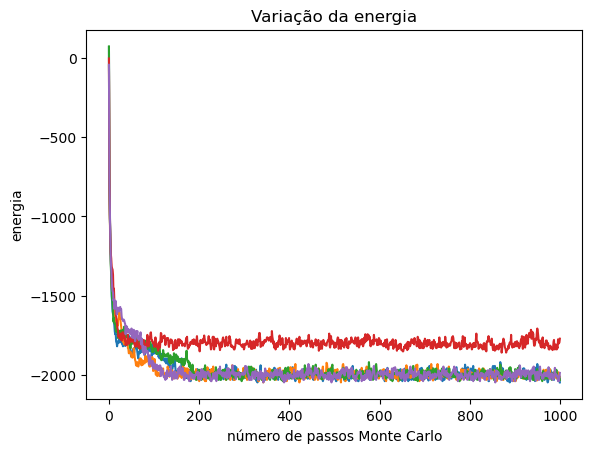

In [10]:
plotar_grafo_linha(arr_energias, "número de passos Monte Carlo", "energia", "Variação da energia")

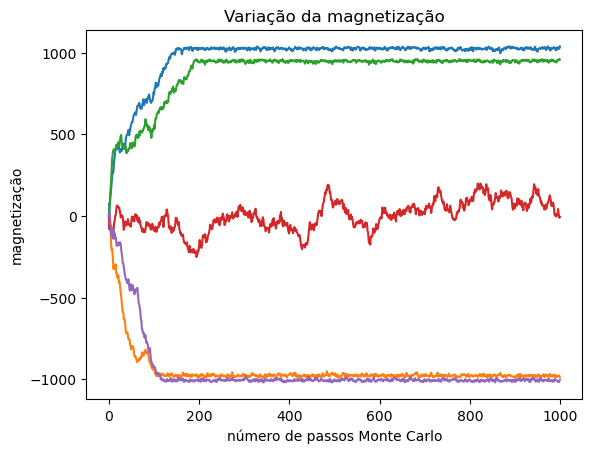

In [11]:
plotar_grafo_linha(arr_magnetizacoes, "número de passos Monte Carlo", "magnetização", "Variação da magnetização")

Análise do efeito da variação da temperatura na energia e magnetização

In [12]:
L = 32
temp_inicial = 0.4
limit=3.0
step=0.2
n_passos = 1000
n = 5
for temp in range(int(temp_inicial*100),int(limit*100+1),int(step*100)):
    temp=temp/100
    if (temp==temp_inicial):
        arr_energias, arr_magnetizacoes = fazer_alg_metropolis_n_vezes(n, L, temp, n_passos)
    else:
        arr_energias_aux, arr_magnetizacoes_aux = fazer_alg_metropolis_n_vezes(n, L, temp, n_passos)
        arr_energias=np.concatenate((arr_energias,arr_energias_aux),0)
        arr_magnetizacoes=np.concatenate((arr_magnetizacoes,arr_magnetizacoes_aux),0)

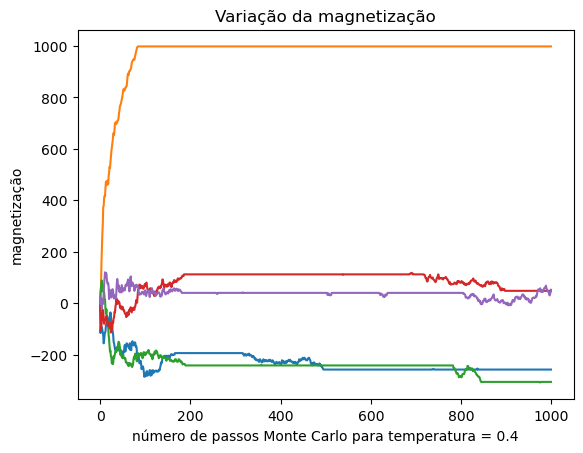

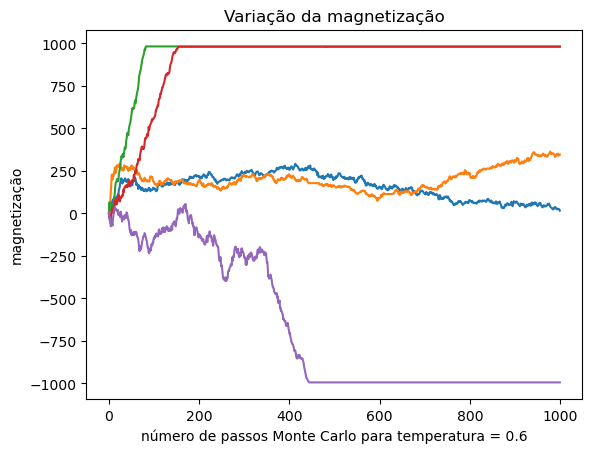

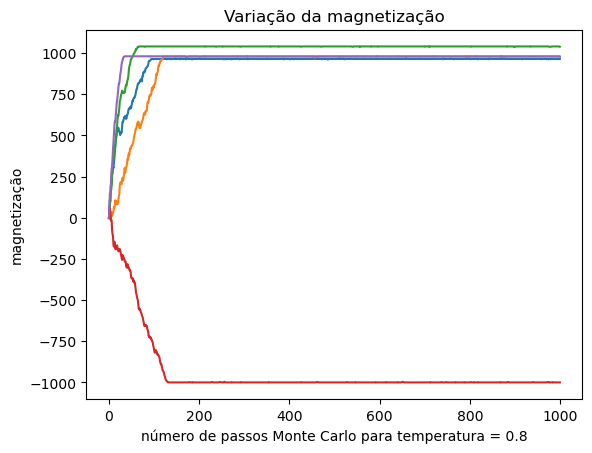

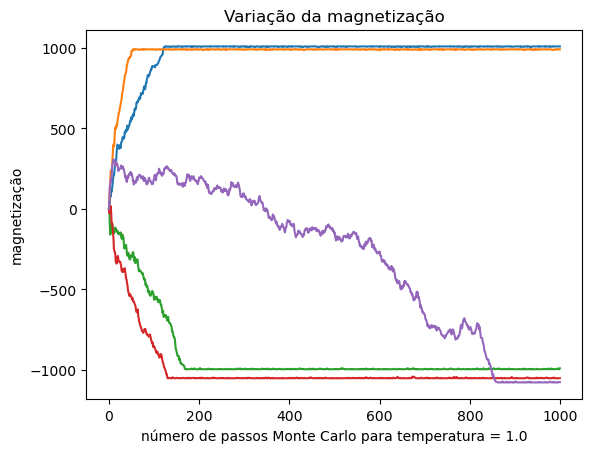

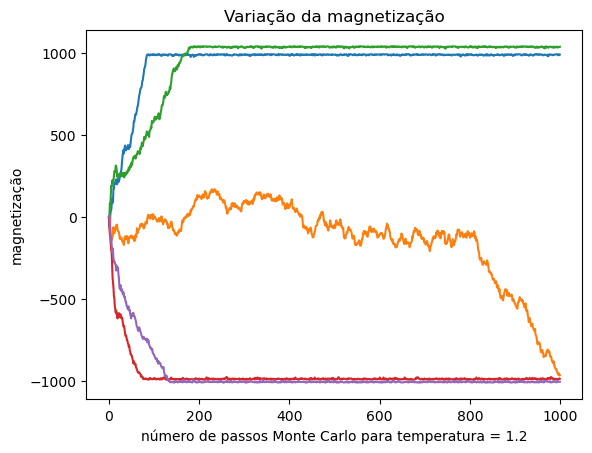

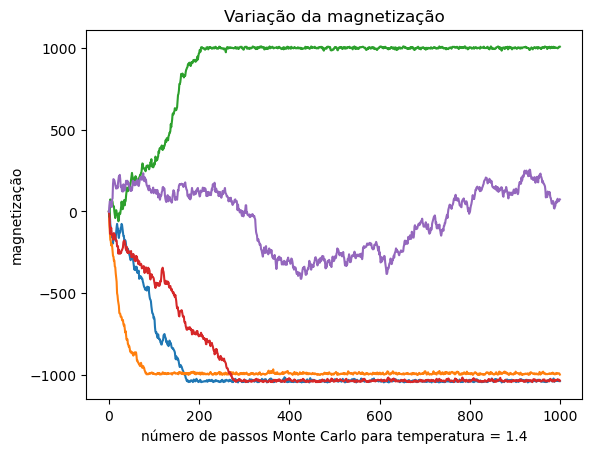

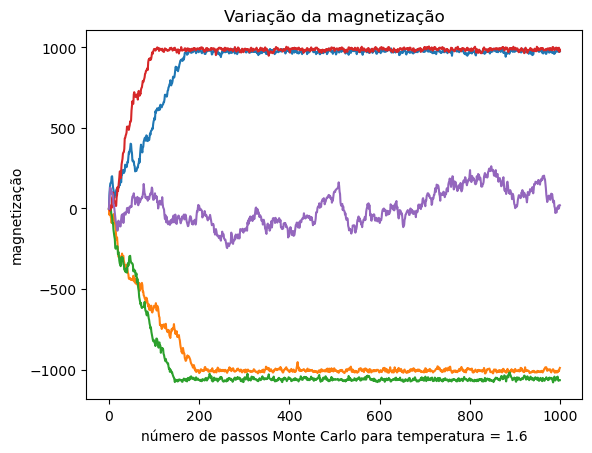

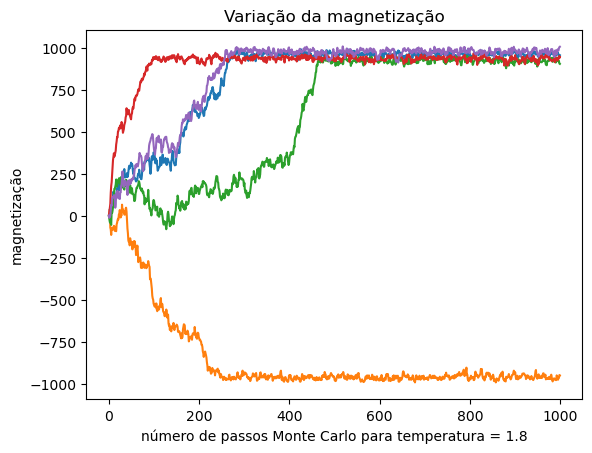

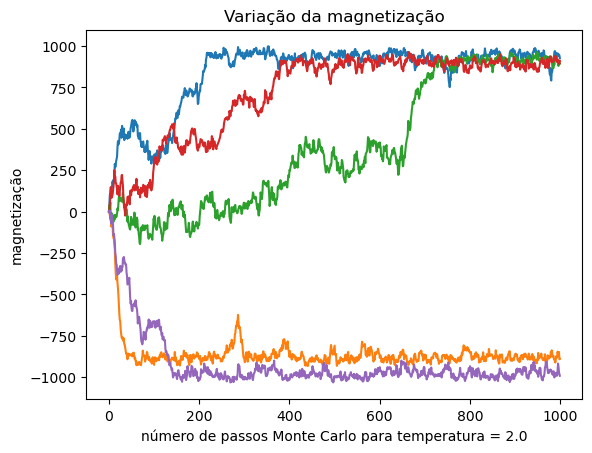

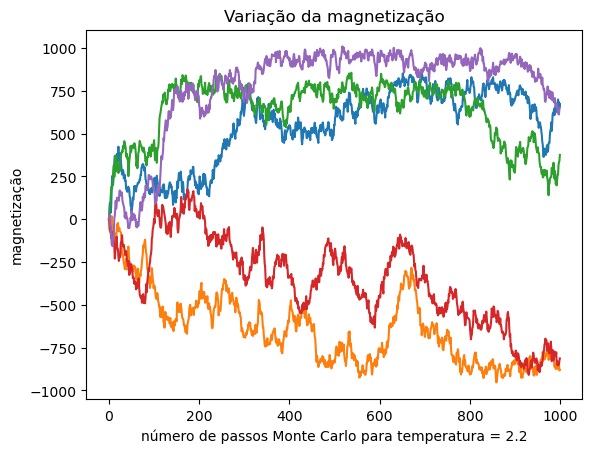

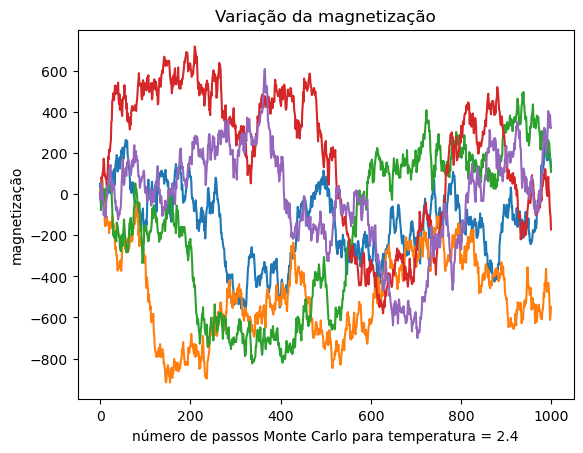

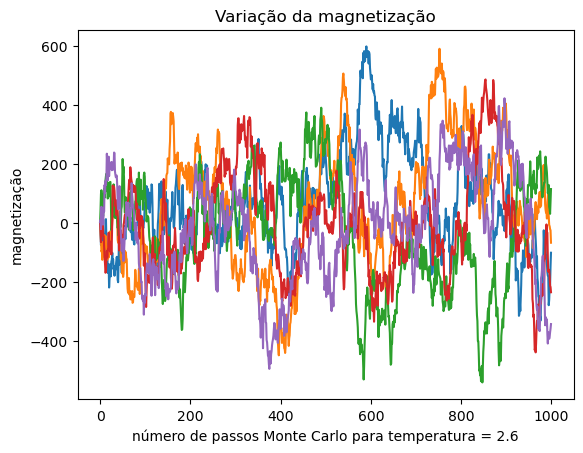

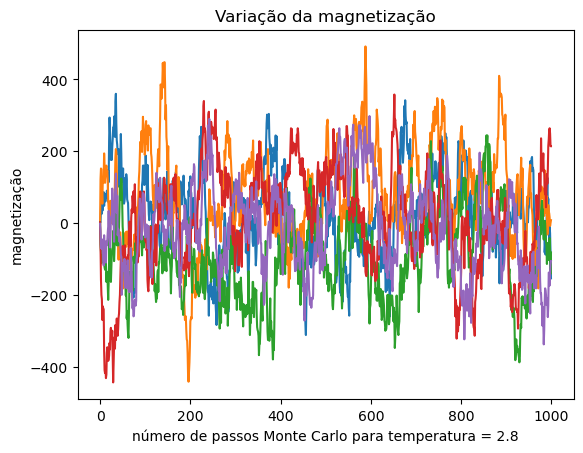

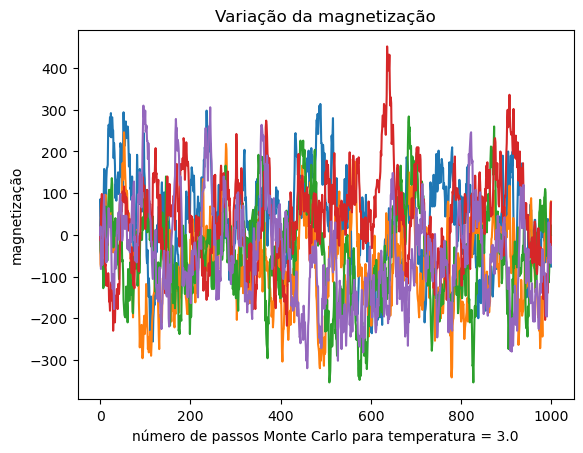

In [13]:
temp=temp_inicial
for i in range(0,arr_energias.shape[0],n):
    plotar_grafo_linha(arr_magnetizacoes[i:i+n], "número de passos Monte Carlo para temperatura = " + str(round(temp,2)), "magnetização", "Variação da magnetização")
    temp=temp+step    

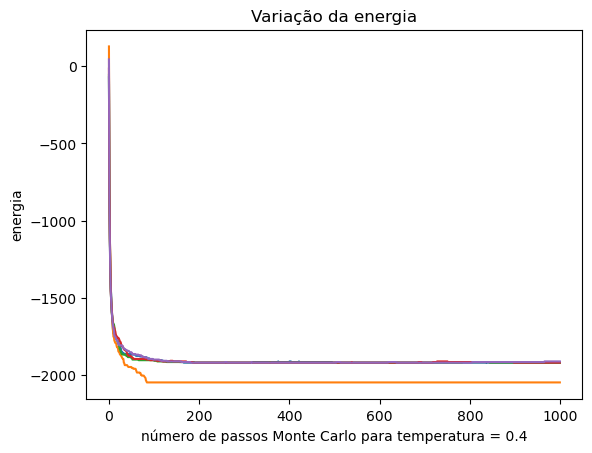

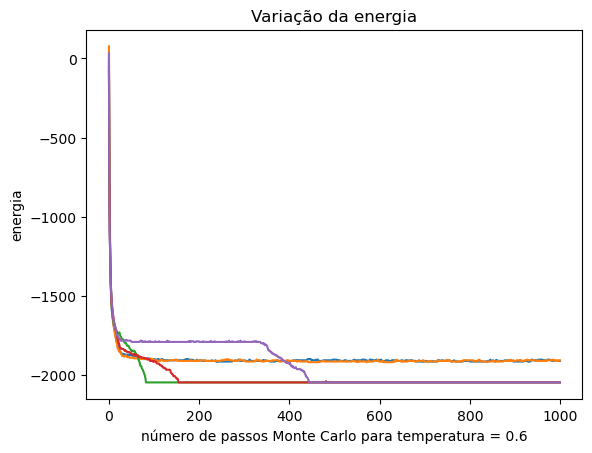

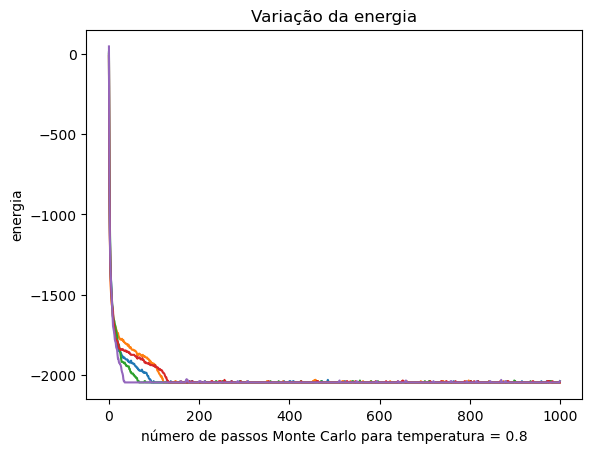

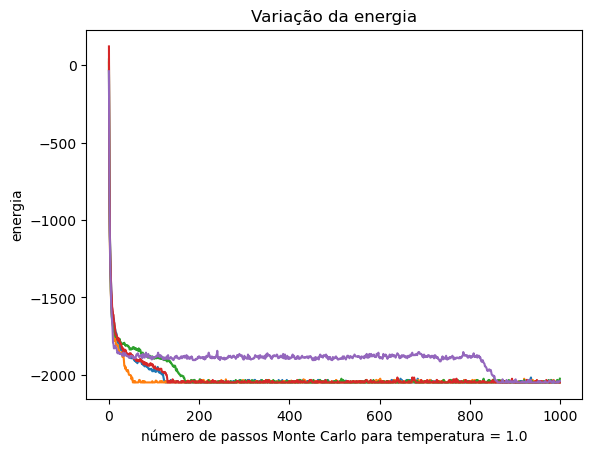

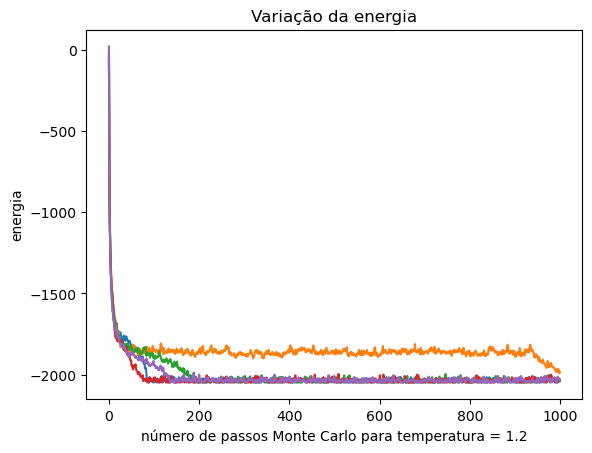

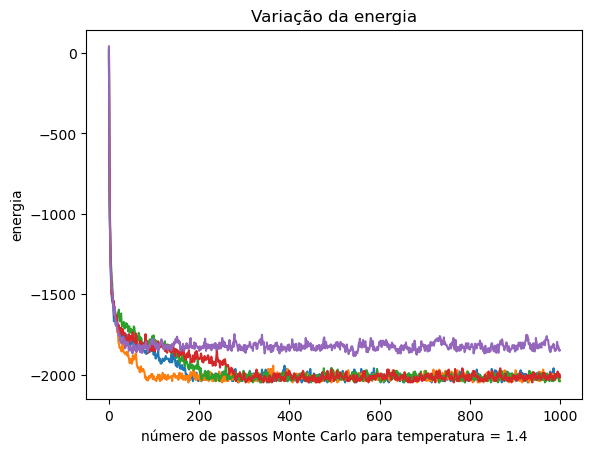

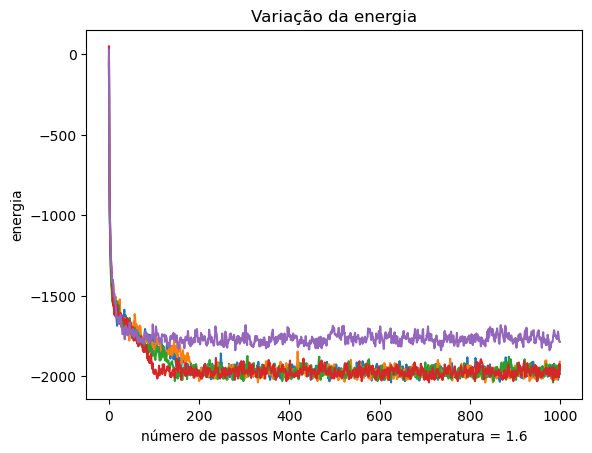

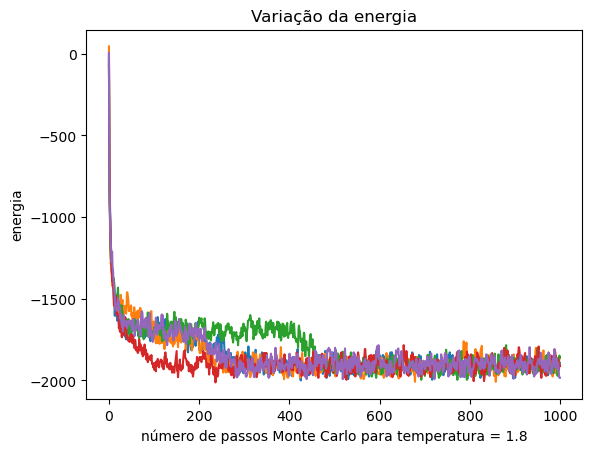

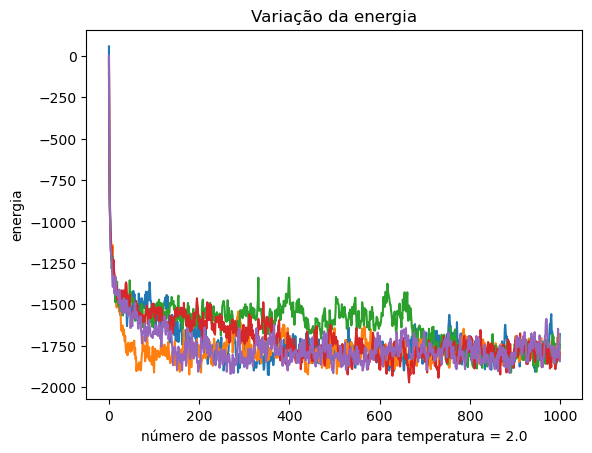

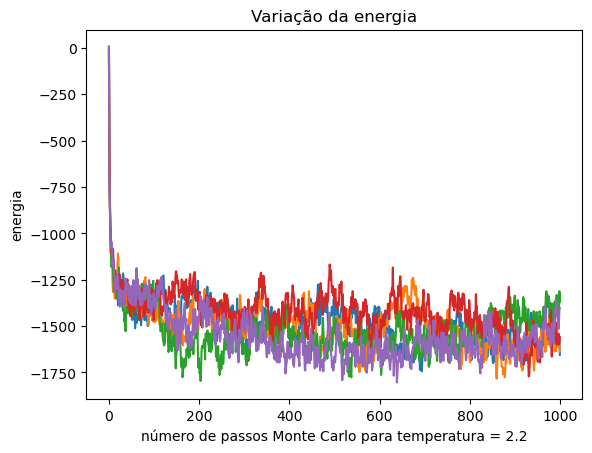

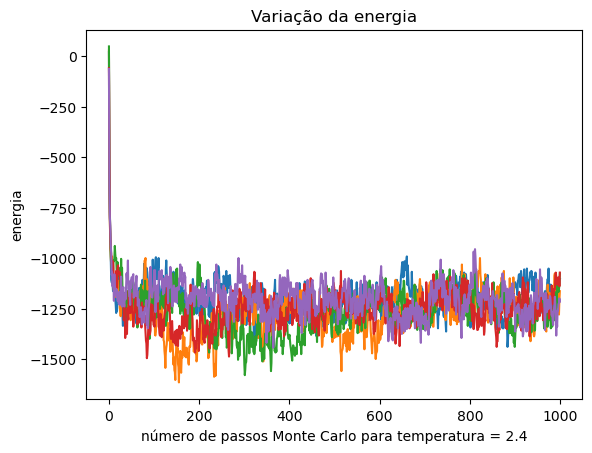

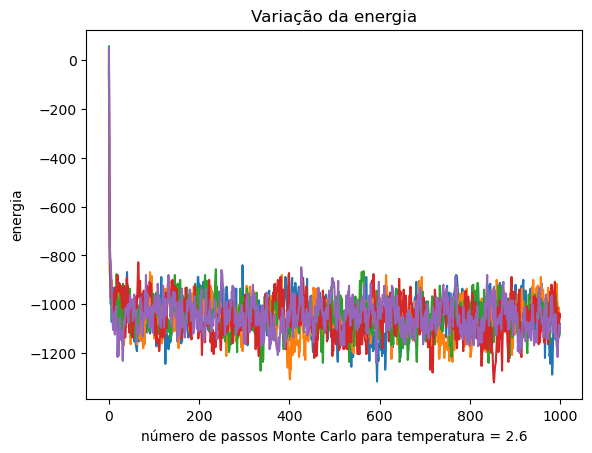

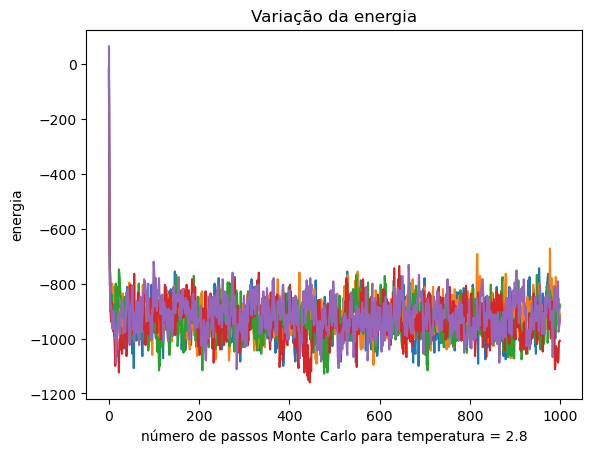

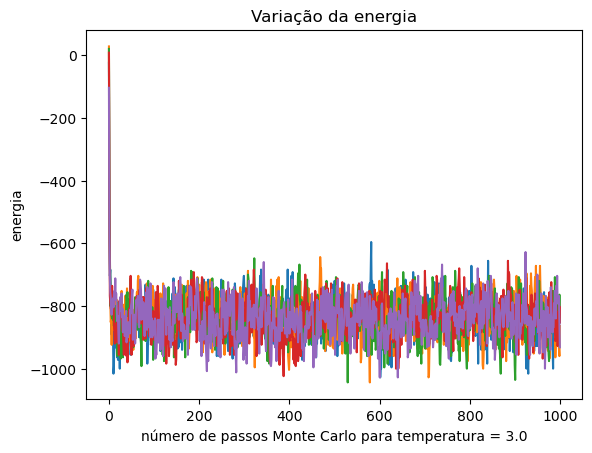

In [14]:
temp=temp_inicial
for i in range(0,arr_energias.shape[0],n):
    plotar_grafo_linha(arr_energias[i:i+n], "número de passos Monte Carlo para temperatura = " + str(round(temp,2)), "energia", "Variação da energia")
    temp=temp+step

# PDF 2

In [15]:
# Cálculo do Calor Específico

def calculate_specific_heat(arr, beta, N):
    mean_energy = np.mean(arr)
    mean_energy_squared = np.mean(arr**2)
    specific_heat = (mean_energy_squared - mean_energy**2)*(beta**2)/N
    return specific_heat

In [16]:
(beta**2)/N

0.00043402777777777775

In [20]:
temp=temp_inicial
for i in range(0,arr_energias.shape[0],n):
  print("Calor específico para iterações com temperatura = " + str(round(temp,1)))
  for j in range(n):
    print(calculate_specific_heat(arr_energias[i+j], beta, N))
  temp=temp+step 

Calor específico para iterações com temperatura = 0.4
2.899683270833217
4.461066048611125
2.9735331597223396
3.1243313263890333
3.0644171597222236
Calor específico para iterações com temperatura = 0.6
3.0242388888887537
3.1758149930554076
5.106343750000128
5.145819437500298
9.444869104166475
Calor específico para iterações com temperatura = 0.8
4.5967652708332025
5.321739159722104
4.790502888889023
4.90899488888883
4.178704715277692
Calor específico para iterações com temperatura = 1.0
4.981120861111372
4.058402083333324
5.668615770833235
5.534611555555683
4.223890861111108
Calor específico para iterações com temperatura = 1.2
5.289798048611273
3.3968121944441614
5.790633305555578
4.8292685486109495
5.096590972222152
Calor específico para iterações com temperatura = 1.4
5.706907111111124
5.1507387777777085
7.581996604166811
7.037756770833261
3.1661039930556094
Calor específico para iterações com temperatura = 1.6
6.607753861111227
7.384156381944599
6.094489659722361
6.484301937500074
3

In [18]:
# Cálculo do Erro Estatístico
from math import sqrt

def stat_err(arr):
  """
  Calculate the statistical error of a measure.
  ------------
  Parameters:
    arr (np.ndarray): array of measures from which the error will be calculated.
  Returns:
    err (integer): the statistical error of the measure.
  """
  avg = arr.mean()
  sum = ((avg - arr)**2).sum()
  err = sqrt(sum / (len(arr) - 1))
  return err
